In [2]:
from SEM import SEM
from Primacy_model import primacy_model
import numpy as np
from matplotlib import pyplot as plt

In [6]:
class ordinal_positional_model(SEM, primacy_model):
    
    def __init__(self, SEM_params, PM_params, EM_threshold):

        SEM.__init__(self, param_dict=SEM_params)
        primacy_model.__init__(self, params_dict=PM_params)
        self.EM_threshold = EM_threshold
        self.num_EM_recalls = 0
        self.group_size = self.list_length # ignoring grouping effects by setting group size to list length
        self.ppr = 0 # proportion of lists correctly recalled 

    def list_presentation_SEM_PM(self, items):

        self.list_presentation(list_length=self.list_length, group_size=self.group_size, items=items)
        self.present_list(items)

    def recall_list_SEM_PM(self):

        for i in range(self.list_length):
            
            correct_item = self.current_list[i]
            
            # add selection noise
            item_act_noisy = self.item_activations + np.random.default_rng().normal(0, self.N, self.vocab_size_PM)

            # retrieve strongest activated item 
            selected_item = np.argmax(item_act_noisy)
            selected_item_act = np.max(item_act_noisy)    

            # add noise to selected item before comparing to output threshold 
            selected_item_act += np.random.default_rng().normal(0, self.M, 1)[0]

            # check if activation of selected item is greater than the threshold
            # if not, cue SEM
            if selected_item_act >= self.EM_threshold:
                # run SEM recall method to decay context and phonological token and suppress item 
                _ = self.recall_selection(i+1, i+1, recalled_item=selected_item)
            else:
                self.num_EM_recalls += 1
                selected_item = self.recall_selection(i+1, i+1)
                
            self.compute_errors(correct_item, selected_item, recall_position=i, 
                                prev_recalled_list=self.previously_recalled_list)

            # set activation of selected item to 0 to model response suppression 
            self.item_activations[selected_item] = 0 
            self.activation_dynamics(recall_mode=True, item_inputs=np.zeros(self.vocab_size_PM))

    def simulate_lists_SEM_PM(self, num_trials):

        self.presented_list_storage = np.zeros((num_trials, self.list_length))
        self.recalled_list_storage = np.zeros((num_trials, self.list_length))

        for i in range(num_trials):

            if i % 2 == 0:
                vocab = np.arange(0,6,1)
            else:
                vocab = np.arange(6,12,1)

            current_list = np.random.default_rng().choice(vocab, self.list_length, replace=False)

            self.presented_list_storage[i] = current_list

            self.list_presentation_SEM_PM(current_list)
            self.recall_list_SEM_PM()
            
            if np.array_equal(self.recalled_list, current_list):
                self.ppr += 1
                
            self.recalled_list_storage[i] = self.recalled_list            

In [4]:
def plot_errors(model, title_str):
    
    recall_pos = np.arange(1,7,1)
    width = 0.15
    plt.figure(figsize=(10,6))
    plt.bar(recall_pos, model.immediate_intrusions/model.frac_errors, width=width, label="Immediate intrusions")    
    plt.bar(recall_pos + width, model.output_protrusions/model.frac_errors, width=width, label="Output protrusions")
    plt.bar(recall_pos+(width*2), model.omissions/model.frac_errors, width=width, label='Omissions')
    plt.bar(recall_pos+(width*3), model.within_list_errors/model.frac_errors, width=width, label='Transpositions + Repetitions')
    plt.legend()
    plt.title(title_str, fontsize=16)    
    plt.ylim(0,1.2)
    plt.show()

In [1]:
params_SEM = {'s0': 1.0, 'e0': 0.6, 'S':0.8 , 'E': 0.48, 'G_c': 0.06, 'G_p':0, 'R_s': 0.50, 
                        'R_p': 0.20, 'T_o': 0.35, 'E_c': 0.98, 'E_l': 0.985, 'C_p': 1, 'C_d': 0, 
                        'C_r': 1, 'C_i':0, 'C_a': 5, 'A_p':0,
                        'P_s':1, 'P_d':0, 'vocab_size_SM':12, 'max_tokens':30, 'omission_val':-1}

params_dict_PM = {'P':11.5, 'D':0.27, 'T':0.49, 'M':0.74, 'N':0.23, 'vocab_size_PM':12, 'input_strength':50, 
                    'item_presentation_rate':0.4, 'blank':0.1, 'R': 4, 
                    'list_length':6, 'output_time': 0.5, 'dt':0.005, 'R_p':0.9}

In [5]:
EM_threshold_SEM_only = 1e7
SEM_only = ordinal_positional_model(params_SEM, params_dict_PM, EM_threshold=EM_threshold_SEM_only)
SEM_only.positional_overlap(list_length=5, plot=True)

KeyError: 'list_length'

In [7]:
num_trials = 1000
SEM_only.simulate_lists_SEM_PM(num_trials)
SEM_only.ppr

NameError: name 'SEM_only' is not defined

In [35]:
print(np.mean(SEM_only.within_list_errors/(SEM_only.frac_errors)))
print(np.mean(SEM_only.intrusions/(SEM_only.frac_errors)))
print(np.mean(SEM_only.omissions/(SEM_only.frac_errors)))

0.14299167663699852
0.0
0.8570083233630014


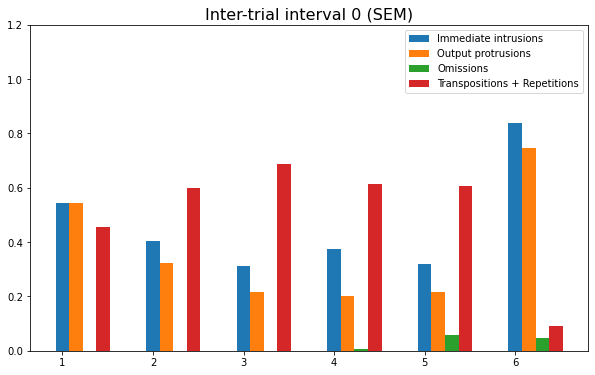

In [26]:
# manipulate inter-trial interval lengths
C_i_arr = [0]
num_trials = 1000
EM_threshold_SEM_only = 1e6
EM_threshold_PM_SEM = 2.5
for c_i in C_i_arr:
    params_SEM['C_i'] = c_i
    SEM_only = ordinal_positional_model(params_SEM, params_dict_PM, EM_threshold=EM_threshold_SEM_only)
    #PM_SEM = ordinal_positional_model(params_SEM, params_dict_PM, EM_threshold=EM_threshold_PM_SEM)
    SEM_only.simulate_lists_SEM_PM(num_trials)
    #PM_SEM.simulate_lists_SEM_PM(num_trials)
    #print(PM_SEM.output_protrusions)
    plot_errors(SEM_only, f"Inter-trial interval {c_i} (SEM)")
    #plot_errors(PM_SEM, f"Inter-trial interval {c_i} (PM+SEM)")

In [27]:
SEM_only.immediate_intrusions

array([  6.,  31.,  51., 111., 110., 183.])

In [4]:
print(f"Fraction of total errors: {SEM_only.frac_errors}")
print(f"Immediate intrusions: {SEM_only.immediate_intrusions}")
print(f"Output protrusions: {SEM_only.output_protrusions}")
print(f"Within list errors: {SEM_only.within_list_errors}")
print(f"Omissions: {SEM_only.omissions}")

Fraction of total errors: [ 16.  59. 185. 339. 392. 222.]
Immediate intrusions: [ 12.  26.  79. 111. 105. 189.]
Output protrusions: [ 12.  25.  55.  59.  65. 164.]
Within list errors: [  4.  33. 105. 219. 247.  21.]
Omissions: [ 0.  0.  0.  5. 35. 10.]


In [6]:
print(f"Fraction of total errors: {PM_SEM.frac_errors}")
print(f"Intrusions: {PM_SEM.immediate_intrusions}")
print(f"Output protrusions: {PM_SEM.output_protrusions}")
print(f"Within list errors: {PM_SEM.within_list_errors}")
print(f"Omissions: {PM_SEM.omissions}")

Fraction of total errors: [ 68. 150. 189. 245. 286. 170.]
Intrusions: [ 0.  0.  1.  0.  7. 21.]
Output protrusions: [ 0.  0.  0.  0.  5. 21.]
Within list errors: [ 68. 150. 188. 245. 279. 149.]
Omissions: [0. 0. 0. 0. 0. 0.]


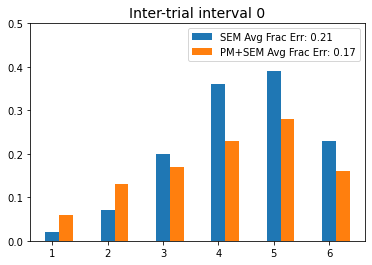

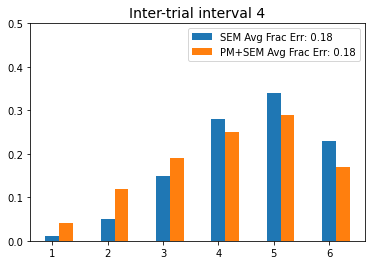

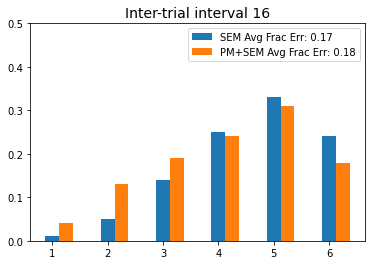

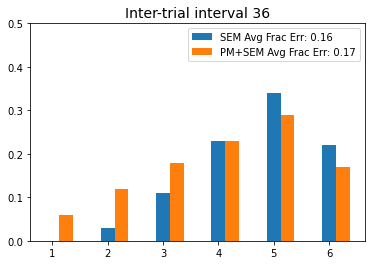

In [11]:
for C_i, perf_odm, perf_sem in zip(C_i_arr, perf_c_i_odm, perf_c_i_SEM):
    
    mean_perf_sem = np.round(np.mean(perf_sem),2)
    mean_perf_odm = np.round(np.mean(perf_odm),2)
    plt.bar(np.arange(1,7,1), perf_sem, width=0.25, label=f'SEM Avg Frac Err: {mean_perf_sem}')
    plt.bar(np.arange(1.25,7.25,1), perf_odm, width=0.25, label=f"PM+SEM Avg Frac Err: {mean_perf_odm}")
    plt.legend()
    plt.ylim(0,.5)
    plt.title(f'Inter-trial interval {C_i}', fontsize=14)
    plt.show()

<h3> Short inter-trial interval </h3> 
Fraction of errors across serial positions: 0.06, 0.14, 0.2, 0.26, 0.32, 0.28 

Number of immediate intrusions: 898  

Number of protrusions: 193 

Number of protrusions expected by chance: 149.6




<h3> Long inter-trial interval </h3> 

Fraction of errors across serial positions: 0.06, 0.14, 0.19, 0.24, 0.31, 0.26 

Number of immediate intrusions: 70 

Number of protrusions: 11 

Number of protrusions expected by chance: 11.6





